# TODO

- Staking
- Log loss(weighted) + Focal loss + Weighted cross entropy loss

# Setting

In [83]:
import sys

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

root_dir = "../../"
if root_dir not in sys.path:
    sys.path.append(root_dir)
from modules import config as cfg
from modules import utils, preprosess, training, predict, metrics

exp = "exp20"
utils.set_seed(cfg.Params.seed)

# Read data

In [84]:
train, test, submit = utils.get_data(debug_mode=False)

# Preprocessing

## Split fold

In [85]:
train = preprosess.assign_stratified_k_fold(train)

## Convert

In [86]:
# 地名を座標に変換
train = preprosess.convert_to_latlon(train)
test  = preprosess.convert_to_latlon(test)

# testのBankStateの"PR"はtrainにないため，一番多いCAに変換
test = test.with_columns(pl.col("BankState").str.replace("PR", "CA"))

# DisbursementDateとApprovalDateをYear(数値)に変換
cols  = ["DisbursementDate", "ApprovalDate"]
train = preprosess.convert_date_to_year(train, cols)
test  = preprosess.convert_date_to_year(test, cols)

# 金額データの数値化
cols  = ["DisbursementGross",  "GrAppv", "SBA_Appv"]
train = preprosess.convert_money_data(train, cols)
test  = preprosess.convert_money_data(test, cols)

# 一致しているか
eqs = [
    ["State", "BankState"],
]
train = preprosess.add_eq(train, eqs)
test  = preprosess.add_eq(test, eqs)

# 差の計算
diffs = [
    ["DisbursementGross", "GrAppv"],   # 支払われた額 vs 銀行承認額
    ["DisbursementGross", "SBA_Appv"], # 支払われた額 vs SBA承認額
    ["GrAppv", "SBA_Appv"],            # 銀行承認額 vs SBA承認額
]
train = preprosess.add_diff(train, diffs)
test  = preprosess.add_diff(test, diffs)

# DisbursementDateとApprovalDateの差を計算
train = preprosess.add_diff_disbursement_with_approval(train)
test  = preprosess.add_diff_disbursement_with_approval(test)

# 割合の計算
divs = [
    # ["DisbursementGross", "Term"],
    ["GrAppv", "Term"],
    ["SBA_Appv", "Term"],
    ["NoEmp", "Term"],
    # ["DisbursementGross", "NoEmp"],
    # ["GrAppv", "NoEmp"],
    # ["SBA_Appv", "NoEmp"],
    ["DisbursementGross_GrAppv_diff", "Term"],
    ["DisbursementGross_SBA_Appv_diff", "Term"],
    ["GrAppv_SBA_Appv_diff", "Term"],
    # ["DisbursementGross_GrAppv_diff", "NoEmp"],
    # ["DisbursementGross_SBA_Appv_diff", "NoEmp"],
    # ["GrAppv_SBA_Appv_diff", "NoEmp"]
]
train = preprosess.add_div(train, divs)
test  = preprosess.add_div(test, divs)

# Sectorを職業別にする
train = preprosess.unify_same_sector(train)
test  = preprosess.unify_same_sector(test)

## Target encoding

In [87]:
cols = [
    # "Sector",
    "UrbanRural",
    "RevLineCr",
    "LowDoc",
    "FranchiseCode",
]
target_col = "MIS_Status"
train, test = preprosess.target_encoding(train, test, cols)

## Label encoding
CVによるtarget encodingでは同じカテゴリカル変数に異なる値が割り当てられるのでlabel encodingを併用する

In [88]:
cols = ["RevLineCr", "LowDoc"]
train, test = preprosess.label_encoding(train, test, cols)

## Loss Weight

In [89]:
weight = [0.82, 0.18]
train = preprosess.add_loss_weight(train, weight)

# Drop columns

In [90]:
# 不要なカラムの削除
del_cols = [
    # 地名系
    "City",
    "State",
    "BankState",
    # d-b-y系
    "DisbursementDate",
    "ApprovalDate",
    "ApprovalFY",
    # ラベルエンコーディング済み
    "RevLineCr",
    "LowDoc",
]
train = train.drop(del_cols)
test  = test.drop(del_cols)

# Training

In [91]:
oof_li = []
models_li = []

## Default

In [92]:
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}
oof, models = training.fit_lgbm(train, lgb_params=lgb_params)
oof_li.append(oof)
models_li.append(models)

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Info] Number of positive: 30213, number of negative: 3632
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5177
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646146 -> initscore=0.602141
[LightGBM] [Info] Start training from score 0.602141
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.794832	training's macro_f1: 0.678921	valid_1's auc: 0.772302	valid_1's macro_f1: 0.684461
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.794832	training's macro_f1: 0.678921	valid_1's auc: 0.772302	valid_1's macro_f1: 0.684461
Time:  13.235[s]
---------------------------------------------------------

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 30213, number of negative: 3632
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646146 -> initscore=0.602141
[LightGBM] [Info] Start training from score 0.602141
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.79475	training's macro_f1: 0.681262	valid_1's auc: 0.770944	valid_1's macro_f1: 0.67352
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.79475	training's macro_f1: 0.681262	valid_1's auc: 0.770944	valid_1's macro_f1: 0.67352
Time:  9.187[s]
--------------------------------------------------------------------------------
START fold 3


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 30214, number of negative: 3632
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5178
[LightGBM] [Info] Number of data points in the train set: 33846, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646154 -> initscore=0.602174
[LightGBM] [Info] Start training from score 0.602174
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.799253	training's macro_f1: 0.686827	valid_1's auc: 0.754556	valid_1's macro_f1: 0.657948
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.799253	training's macro_f1: 0.686827	valid_1's auc: 0.754556	valid_1's macro_f1: 0.657948
Time:  8.038[s]
--------------------------------------------------------------------------------
START f

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 30214, number of negative: 3632
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5174
[LightGBM] [Info] Number of data points in the train set: 33846, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646154 -> initscore=0.602174
[LightGBM] [Info] Start training from score 0.602174
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795917	training's macro_f1: 0.682867	valid_1's auc: 0.764371	valid_1's macro_f1: 0.666525
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.795917	training's macro_f1: 0.682867	valid_1's auc: 0.764371	valid_1's macro_f1: 0.666525
Time:  7.613[s]
--------------------------------------------------------------------------------
START f

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 30214, number of negative: 3632
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5177
[LightGBM] [Info] Number of data points in the train set: 33846, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646154 -> initscore=0.602174
[LightGBM] [Info] Start training from score 0.602174
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.79625	training's macro_f1: 0.679722	valid_1's auc: 0.767476	valid_1's macro_f1: 0.675309
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.79625	training's macro_f1: 0.679722	valid_1's auc: 0.767476	valid_1's macro_f1: 0.675309
Time:  8.011[s]
FINISH!


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


## Focal Loss

In [93]:
# Focal loss
lgb_params = {
    'objective': 'binary',
    'metric': 'custom',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}
drop_cols = [cfg.Cols.weight]
oof, models = training.fit_lgbm_fl(train, drop_cols=drop_cols, lgb_params=lgb_params, alpha=0.2, gamma=2.0)
oof_li.append(oof)
models_li.append(models)

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5177
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 200 rounds
[100]	training's Focal_alpha0.2_gamma2.0: 0.0277958	valid_1's Focal_alpha0.2_gamma2.0: 0.046064
Did not meet early stopping. Best iteration is:
[100]	training's Focal_alpha0.2_gamma2.0: 0.0277958	valid_1's Focal_alpha0.2_gamma2.0: 0.046064
Time:  4.956[s]
--------------------------------------------------------------------------------
START fold 2
[LightGBM] [Warning]

## Weighted Cross Entropy Loss

In [94]:
# Cross entropy loss
lgb_params = {
    'objective': 'binary',
    'metric': 'custom',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}
drop_cols = [cfg.Cols.weight]
oof, models = training.fit_lgbm_wcel(train, drop_cols=drop_cols, lgb_params=lgb_params, alpha=0.35)
oof_li.append(oof)
models_li.append(models)

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5177
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 200 rounds
[100]	training's WCE_alpha0.35: 0.210405	valid_1's WCE_alpha0.35: 0.211012
Did not meet early stopping. Best iteration is:
[100]	training's WCE_alpha0.35: 0.210405	valid_1's WCE_alpha0.35: 0.211012
Time:  2.883[s]
--------------------------------------------------------------------------------
START fold 2
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the ov

## Stacking

In [95]:
logistic_regression_params = {
    'penalty': 'l2',
    'C': 1.0,
    'max_iter': 100,
    'solver': 'lbfgs',
    'random_state': cfg.Params.seed,
    'class_weight': "balanced",
}
oof, meta_models = training.fit_stacking(train, oof_li)

--------------------------------------------------------------------------------
START fold 1
Time:  0.146[s]
--------------------------------------------------------------------------------
START fold 2
Time:  0.027[s]
--------------------------------------------------------------------------------
START fold 3
Time:  0.029[s]
--------------------------------------------------------------------------------
START fold 4
Time:  0.029[s]
--------------------------------------------------------------------------------
START fold 5
Time:  0.029[s]
FINISH!


# Predict

In [114]:
threshold = 0.75

## CV score

In [115]:
oof_truth = train[cfg.Cols.target].to_numpy()
oof_hat = predict.predict_class(oof, threshold=threshold)
cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
print(cv_score)

0.6761099375960129


In [116]:
pred_probs = []
for i, models in enumerate(models_li):
    if i == 0:
        # default
        pred_probs.append(predict.predict_probability(models, test))
    else:
        # Focal loss or Cross entropy loss
        pred_probs.append(predict.predict_probability_sigmoid(models, test))
pred_prob = predict.predict_probability_stacking(meta_models, pred_probs)
pred_class = predict.predict_class(pred_prob, threshold=threshold)

## Check result

### oofとtestの予測値分布を比較してバグを確認

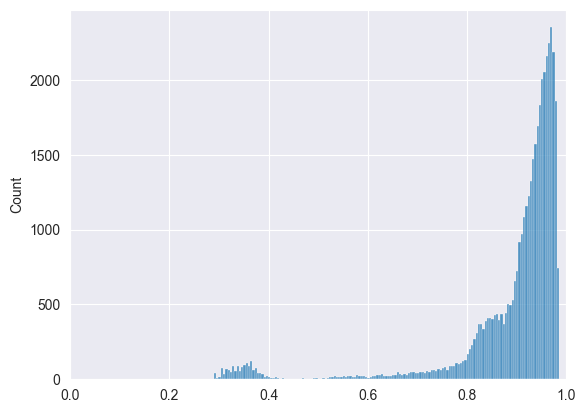

In [117]:
sns.histplot(oof)
plt.xlim(0.0, 1.0)
plt.show()

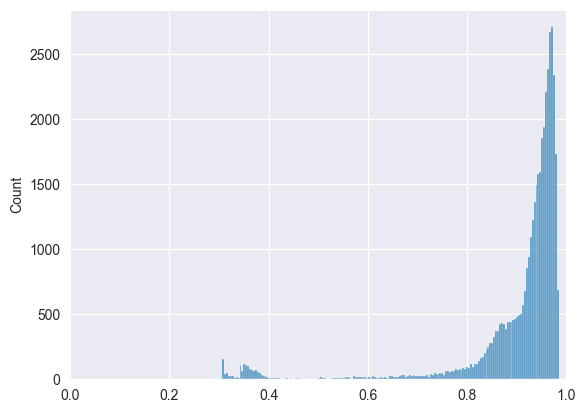

In [118]:
sns.histplot(pred_prob)
plt.xlim(0.0, 1.0)
plt.show()

### 予測値の1の割合を確認

In [119]:
print(pred_class.sum() / len(pred_class))

0.935756830859412


### oofにおける混同行列を確認

True Negative Rate (0の正解率): 0.35
True Positive Rate (1の正解率): 0.96


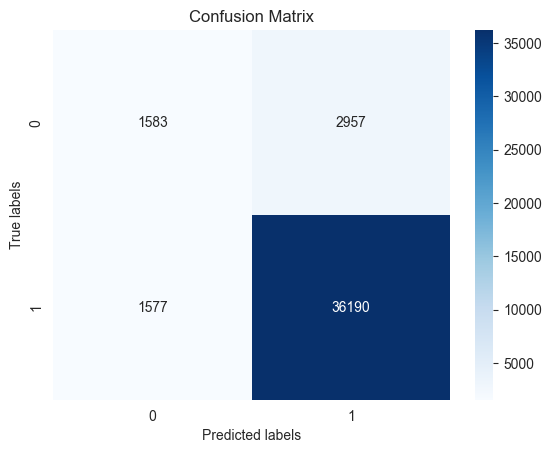

In [120]:
metrics.show_confusion_matrix(oof_truth, oof_hat)

## Submit

In [121]:
submit = submit.with_columns([pl.Series(cfg.Cols.sub_pred, pred_class)])
utils.make_submission(submit, exp, cv_score)